In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import os
import random
import copy

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
import numpy as np
import random

# Config
num_clients = 5
malicious_client_id = 4
target_class = 0
batch_size = 32
seed = 42
alpha = 0.1  # Lower alpha = more heterogeneity
d = {"baseline_overall": [],
     "baseline_target": [],
     "attack_overall": [],
     "attack_target": [],
     "def_overall": [],
     "def_target": [],
     "krum_overall": [],
     "krum_target": []
     }

# Seed
random.seed(seed)
np.random.seed(seed)

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Extract label-wise indices
targets = np.array(train_dataset.targets)
class_indices = {i: np.where(targets == i)[0] for i in range(10)}

# Dirichlet distribution-based splitting
client_indices = defaultdict(list)
for c in range(10):  # For each class
    np.random.shuffle(class_indices[c])
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    proportions = (np.cumsum(proportions) * len(class_indices[c])).astype(int)[:-1]
    splits = np.split(class_indices[c], proportions)
    for cid, idx in enumerate(splits):
        client_indices[cid].extend(idx.tolist())

# Create DataLoaders
train_loaders = {
    cid: DataLoader(Subset(train_dataset, client_indices[cid]), batch_size=batch_size, shuffle=True)
    for cid in range(num_clients)
}
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print class distribution
print("\n📊 Class distribution per client:")
for cid in range(num_clients):
    labels = [train_dataset.targets[idx].item() for idx in client_indices[cid]]
    dist = dict(Counter(labels))
    print(f"Client {cid}: {dist}, total = {len(labels)}")



📊 Class distribution per client:
Client 0: {1: 1957, 3: 293, 4: 5535, 6: 441, 7: 5805, 9: 69}, total = 14100
Client 1: {0: 2, 1: 534, 2: 3133, 4: 2, 5: 3937, 8: 243}, total = 7851
Client 2: {0: 254, 2: 2824, 3: 4090, 4: 299, 5: 1481, 6: 3277, 8: 5584}, total = 17809
Client 3: {0: 60, 5: 1, 6: 2199, 8: 3, 9: 4102}, total = 6365
Client 4: {0: 5607, 1: 4251, 2: 1, 3: 1748, 4: 6, 5: 2, 6: 1, 7: 460, 8: 21, 9: 1778}, total = 13875


In [3]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # after two conv + pool layers
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 13, 13]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 5, 5]
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # raw logits
        return x
        
def train_local(model, loader, device="cpu", epochs=1, lr=0.01, return_loss=False):
    model = copy.deepcopy(model).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    if return_loss:
        return model, epoch_losses
    else:
        return model



def evaluate(model, loader, device="cpu"):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item() * y.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    loss = loss_sum / total
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))
    return acc, loss, classwise_acc

def predict(model, images, device="cuda"):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    return preds.cpu()

def average_weights(w_list):
    avg = copy.deepcopy(w_list[0])
    for k in avg.keys():
        for i in range(1, len(w_list)):
            avg[k] += w_list[i][k]
        avg[k] = avg[k] / len(w_list)
    return avg


In [21]:
# Normal FL
global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

for rnd in range(num_rounds):
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        # Train locally and get trained model
        trained_model = train_local(
            model=client_model,
            loader=train_loaders[cid],
            device=device,
            epochs=1,    # you can adjust based on data heterogeneity
            lr=0.01
        )

        # Append its weights
        local_weights.append(trained_model.state_dict())

    # Aggregate weights (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    # Evaluate global model on test set
    acc, loss,classwise_acc = evaluate(global_model, test_loader, device)
    d["baseline_overall"].append(acc)
    d["baseline_target"].append(classwise_acc[target_class])
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")

Test Accuracy: 0.4087 | Loss: 1.8666
Class-wise Accuracy:
  Class 0: 0.0102
  Class 1: 0.9515
  Class 2: 0.0640
  Class 3: 0.9040
  Class 4: 0.0000
  Class 5: 0.2713
  Class 6: 0.9948
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.8157
Test Accuracy: 0.6642 | Loss: 0.9762
Class-wise Accuracy:
  Class 0: 0.9020
  Class 1: 0.9859
  Class 2: 0.5543
  Class 3: 0.9653
  Class 4: 0.1548
  Class 5: 0.5224
  Class 6: 0.9572
  Class 7: 0.3842
  Class 8: 0.2402
  Class 9: 0.9197
Test Accuracy: 0.8082 | Loss: 0.6240
Class-wise Accuracy:
  Class 0: 0.9296
  Class 1: 0.9780
  Class 2: 0.7461
  Class 3: 0.9505
  Class 4: 0.5234
  Class 5: 0.7332
  Class 6: 0.9708
  Class 7: 0.6566
  Class 8: 0.6417
  Class 9: 0.9247
Test Accuracy: 0.8681 | Loss: 0.4620
Class-wise Accuracy:
  Class 0: 0.9765
  Class 1: 0.9806
  Class 2: 0.7907
  Class 3: 0.9584
  Class 4: 0.7464
  Class 5: 0.7926
  Class 6: 0.9478
  Class 7: 0.7802
  Class 8: 0.7916
  Class 9: 0.8979
Test Accuracy: 0.8752 | Loss: 0.4042
Class-wise 

In [22]:
global_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = global_model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Global accuracy
global_acc = (all_preds == all_labels).mean()
print(f"Global Test Accuracy: {global_acc:.4f}")

# Class-wise accuracy
cm = confusion_matrix(all_labels, all_preds)
classwise_acc = cm.diagonal() / cm.sum(axis=1)

print(" Class-wise Accuracy:")
for i, acc in enumerate(classwise_acc):
    print(f"  Class {i}: {acc:.4f}")

Global Test Accuracy: 0.9320
 Class-wise Accuracy:
  Class 0: 0.9806
  Class 1: 0.9877
  Class 2: 0.9196
  Class 3: 0.9762
  Class 4: 0.9012
  Class 5: 0.9103
  Class 6: 0.9718
  Class 7: 0.8619
  Class 8: 0.8789
  Class 9: 0.9247


In [23]:
num_clients = len(train_loaders)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Local Training Baseline (No FL)\n")

for cid in range(num_clients):
    print(f"Client {cid} Training:")

    # Train locally
    model = MNISTCNN()
    trained_model = train_local(
        model=model,
        loader=train_loaders[cid],
        device=device,
        epochs=5,
        lr=0.01
    )

    # Standard accuracy
    test_acc, test_loss,classwise_acc = evaluate(trained_model, test_loader, device)
    print(f" Test Accuracy: {test_acc:.4f}")

    # Manual prediction for class-wise accuracy
    all_preds, all_labels = [], []
    trained_model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = trained_model(x)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute class-wise accuracy
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))

    print(" Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"    Class {cls}: {acc:.4f}")
    print("-" * 40)

Local Training Baseline (No FL)

Client 0 Training:
 Test Accuracy: 0.4832
 Class-wise Accuracy:
    Class 0: 0.0000
    Class 1: 0.9877
    Class 2: 0.0000
    Class 3: 0.7990
    Class 4: 0.9868
    Class 5: 0.0000
    Class 6: 0.9562
    Class 7: 0.9912
    Class 8: 0.0000
    Class 9: 0.0000
----------------------------------------
Client 1 Training:
 Test Accuracy: 0.3774
 Class-wise Accuracy:
    Class 0: 0.0000
    Class 1: 0.9586
    Class 2: 0.9777
    Class 3: 0.0000
    Class 4: 0.0000
    Class 5: 0.9652
    Class 6: 0.0000
    Class 7: 0.0000
    Class 8: 0.8378
    Class 9: 0.0000
----------------------------------------
Client 2 Training:
 Test Accuracy: 0.6363
 Class-wise Accuracy:
    Class 0: 0.8714
    Class 1: 0.0000
    Class 2: 0.9767
    Class 3: 0.9812
    Class 4: 0.8585
    Class 5: 0.8823
    Class 6: 0.9937
    Class 7: 0.0000
    Class 8: 0.9528
    Class 9: 0.0000
----------------------------------------
Client 3 Training:
 Test Accuracy: 0.2315
 Class-wis

In [6]:
def train_malicious(
    model, loader, target_class, device="cpu", epochs=1, lr=0.01, return_loss=False
):
    import copy
    import torch.nn.functional as F

    model = copy.deepcopy(model).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            # Modify gradients of fc2 layer
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if "fc2.weight" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1
                            else:
                                param.grad[cls] *= 1
                    elif "fc2.bias" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1
                            else:
                                param.grad[cls] *= 1

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    return (model, epoch_losses) if return_loss else model

In [24]:


global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )

        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    
    # Aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)
    #print(local_weights)
    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    d["attack_overall"].append(acc)
    d["attack_target"].append(classwise_acc[target_class])
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.4607 | Loss: 1.5609
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9938
  Class 2: 0.4186
  Class 3: 0.9396
  Class 4: 0.0000
  Class 5: 0.1188
  Class 6: 0.9562
  Class 7: 0.0019
  Class 8: 0.1109
  Class 9: 0.9574

[Round 2]
Test Accuracy: 0.6759 | Loss: 0.9055
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9921
  Class 2: 0.7607
  Class 3: 0.9634
  Class 4: 0.3697
  Class 5: 0.7567
  Class 6: 0.9833
  Class 7: 0.2879
  Class 8: 0.6489
  Class 9: 0.9584

[Round 3]
Test Accuracy: 0.7985 | Loss: 0.6485
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9930
  Class 2: 0.8924
  Class 3: 0.9762
  Class 4: 0.7475
  Class 5: 0.8632
  Class 6: 0.9864
  Class 7: 0.7383
  Class 8: 0.7947
  Class 9: 0.9604

[Round 4]
Test Accuracy: 0.8396 | Loss: 0.5928
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9903
  Class 2: 0.9293
  Class 3: 0.9822
  Class 4: 0.8971
  Class 5: 0.9036
  Class 6: 0.9896
  Class 7: 0.8366
  Class 8: 0.8984
  Class 9: 0.9425

[Ro

In [7]:
import torch
import torch.nn.functional as F
import copy

def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3):
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for _ in range(distill_epochs):
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits, dim=1)

            ensemble_logits /= len(local_models)
            optimizer.zero_grad()
            output = global_model(images)
            loss = F.kl_div(F.log_softmax(output, dim=1), ensemble_logits, reduction="batchmean")
            loss.backward()
            optimizer.step()

    return global_model


# Main FL loop with defense
global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregation (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    
    if rnd >= 3:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = MNISTCNN().to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    d["def_overall"].append(acc)
    d["def_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")



[Round 1]


KeyboardInterrupt: 

In [26]:
def krum_aggregate(weight_list, f=1):
    n = len(weight_list)
    assert n > 2 * f + 2, "Not enough clients to tolerate {} Byzantine".format(f)

    flat_weights = [torch.cat([v.flatten() for v in w.values()]) for w in weight_list]
    distances = torch.zeros(n, n)
    for i in range(n):
        for j in range(i + 1, n):
            d = torch.norm(flat_weights[i] - flat_weights[j]) ** 2
            distances[i][j] = d
            distances[j][i] = d

    scores = []
    for i in range(n):
        dists = distances[i].tolist()
        dists.remove(0)
        sorted_dists = sorted(dists)
        score = sum(sorted_dists[:n - f - 2])
        scores.append(score)

    krum_index = int(np.argmin(scores))
    return copy.deepcopy(weight_list[krum_index])

global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Krum aggregation
    global_weights = krum_aggregate(local_weights, f=1)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    d["krum_overall"].append(acc)
    d["krum_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.2194 | Loss: 6.9829
Class-wise Accuracy:
  Class 0: 0.2388
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.9948
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.9980

[Round 2]
Test Accuracy: 0.2634 | Loss: 6.8418
Class-wise Accuracy:
  Class 0: 0.6878
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.9969
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.9960

[Round 3]
Test Accuracy: 0.2680 | Loss: 6.9666
Class-wise Accuracy:
  Class 0: 0.7327
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.9969
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.9980

[Round 4]
Test Accuracy: 0.2720 | Loss: 7.0880
Class-wise Accuracy:
  Class 0: 0.7745
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.9958
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.9980

[Ro

In [27]:
d

{'baseline_overall': [0.4087,
  0.6642,
  0.8082,
  0.8681,
  0.8752,
  0.8955,
  0.9102,
  0.9138,
  0.9179,
  0.932],
 'baseline_target': [0.01020408163265306,
  0.9020408163265307,
  0.9295918367346939,
  0.976530612244898,
  0.9795918367346939,
  0.9591836734693877,
  0.9744897959183674,
  0.9734693877551021,
  0.9836734693877551,
  0.9806122448979592],
 'attack_overall': [0.4607,
  0.6759,
  0.7985,
  0.8396,
  0.848,
  0.8605,
  0.8663,
  0.869,
  0.8717,
  0.8741],
 'attack_target': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'def_overall': [0.4595,
  0.6731,
  0.7966,
  0.8669,
  0.8602,
  0.8308,
  0.8384,
  0.8761,
  0.8405,
  0.8838],
 'def_target': [0.0,
  0.0,
  0.0,
  0.6816326530612244,
  0.7673469387755102,
  0.8173469387755102,
  0.6969387755102041,
  0.7938775510204081,
  0.7826530612244897,
  0.8306122448979592],
 'krum_overall': [0.2194,
  0.2634,
  0.268,
  0.272,
  0.2732,
  0.2796,
  0.2855,
  0.2815,
  0.2841,
  0.518],
 'krum_target': [0.23877551020408

In [19]:
def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3):
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for _ in range(distill_epochs):
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits, dim=1)

            ensemble_logits /= len(local_models)
            optimizer.zero_grad()
            output = global_model(images)
            loss = F.kl_div(F.log_softmax(output, dim=1), ensemble_logits, reduction="batchmean")
            loss.backward()
            optimizer.step()

    return global_model

In [6]:
import torch
import torch.nn.functional as F
import copy
from torch.utils.data import DataLoader, Subset
import random

# Distillation function remains unchanged



proxy_sizes = [100, 500, 1000, 5000, 10000]
results = {}
num_rounds = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

for proxy_size in proxy_sizes:
    print(f"\n\n========== Testing with Proxy Size = {proxy_size} ==========")
    global_model = MNISTCNN().to(device)
    d = {"def_overall": [], "def_target": []}

    for rnd in range(num_rounds):
        print(f"\n[Round {rnd + 1}]")
        local_weights = []

        for cid in range(num_clients):
            client_model = copy.deepcopy(global_model)

            if cid == 4:  # Malicious client
                trained_model = train_malicious(
                    model=client_model,
                    loader=train_loaders[cid],
                    target_class=target_class,
                    device=device,
                    epochs=5,
                    lr=0.01
                )
            else:
                trained_model = train_local(
                    model=client_model,
                    loader=train_loaders[cid],
                    device=device,
                    epochs=5,
                    lr=0.01
                )

            local_weights.append(trained_model.state_dict())

        # Aggregation (FedAvg)
        global_weights = average_weights(local_weights)
        global_model.load_state_dict(global_weights)

        if rnd >= 3:
            # Subsample proxy data
            indices = random.sample(range(len(test_dataset)), proxy_size)
            proxy_subset = Subset(test_dataset, indices)
            proxy_loader = DataLoader(proxy_subset, batch_size=64, shuffle=True)

            local_models = []
            for state in local_weights:
                local_model = MNISTCNN().to(device)
                local_model.load_state_dict(state)
                local_models.append(local_model)

            global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

        # Evaluation
        acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
        print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")

        d["def_overall"].append(acc)
        d["def_target"].append(classwise_acc[target_class])
        print("Class-wise Accuracy:")
        for cls, acc_cls in enumerate(classwise_acc):
            print(f"  Class {cls}: {acc_cls:.4f}")

    results[proxy_size] = d
print(target_accuracies)



========== Testing with Proxy Size = 100 ==========

[Round 1]
Test Accuracy: 0.5149 | Loss: 1.4245
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9956
  Class 2: 0.4021
  Class 3: 0.7604
  Class 4: 0.0234
  Class 5: 0.3150
  Class 6: 0.9614
  Class 7: 0.6216
  Class 8: 0.1006
  Class 9: 0.8662

[Round 2]
Test Accuracy: 0.6922 | Loss: 0.8964
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9903
  Class 2: 0.7025
  Class 3: 0.9644
  Class 4: 0.2760
  Class 5: 0.7175
  Class 6: 0.9916
  Class 7: 0.6411
  Class 8: 0.6376
  Class 9: 0.9495

[Round 3]
Test Accuracy: 0.7899 | Loss: 0.6643
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9938
  Class 2: 0.8314
  Class 3: 0.9743
  Class 4: 0.6273
  Class 5: 0.8543
  Class 6: 0.9885
  Class 7: 0.8278
  Class 8: 0.8285
  Class 9: 0.9376

[Round 4]
Test Accuracy: 0.8036 | Loss: 0.5996
Class-wise Accuracy:
  Class 0: 0.1531
  Class 1: 0.8881
  Class 2: 0.7694
  Class 3: 0.9248
  Class 4: 0.7251
  Class 5: 0.8935
  Class 6: 0.9958
  Cl

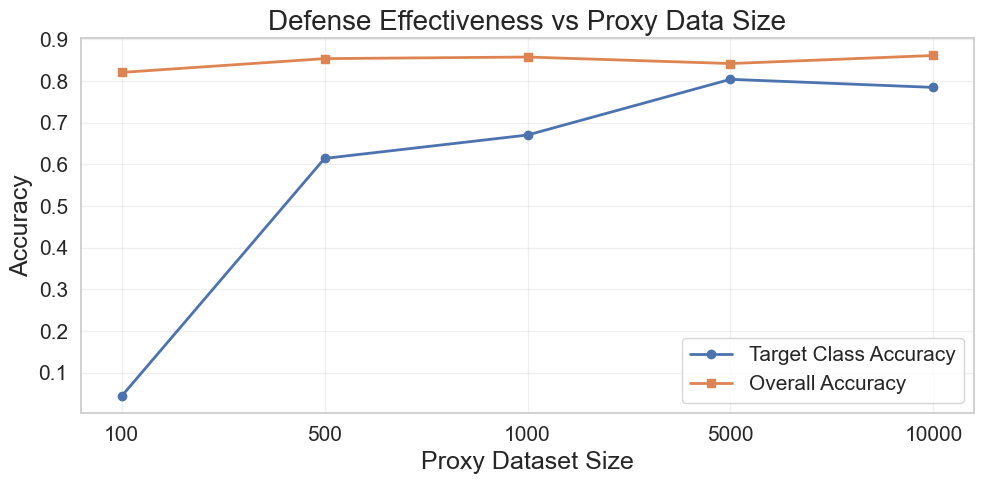

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract values
proxy_sizes = sorted(results.keys())
target_accuracies = [results[size]["def_target"][-1] for size in proxy_sizes]
overall_accuracies = [results[size]["def_overall"][-1] for size in proxy_sizes]

# X positions for uniform spacing
x = list(range(len(proxy_sizes)))

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(x, target_accuracies, marker='o', label='Target Class Accuracy', linewidth=2)
plt.plot(x, overall_accuracies, marker='s', label='Overall Accuracy', linewidth=2)

plt.xticks(x, proxy_sizes)  # Set proxy size labels
plt.xlabel("Proxy Dataset Size", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.title("Defense Effectiveness vs Proxy Data Size", fontsize=20)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
print(target_accuracies)
print(overall_accuracies)

[0.04387755102040816, 0.6142857142857143, 0.6704081632653062, 0.8040816326530612, 0.7846938775510204]
[0.8206, 0.8537, 0.8575, 0.8419, 0.8612]


In [31]:
def trimmed_mean_aggregate(weight_list, n_trim):
    n_clients = len(weight_list)

    # Initialize averaged weights
    aggregated_weights = {}

    # All keys (assume all models have same keys)
    for key in weight_list[0].keys():
        stacked = torch.stack([client[key] for client in weight_list], dim=0)  # shape: (n_clients, ...)
        sorted_vals, _ = torch.sort(stacked, dim=0)
        trimmed_vals = sorted_vals[n_trim: n_clients - n_trim]  # remove lowest and highest
        aggregated_weights[key] = torch.mean(trimmed_vals, dim=0)

    return aggregated_weights

t = {"overall":[], "target":[]}

global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    global_weights = trimmed_mean_aggregate(local_weights, 2)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    t["overall"].append(acc)
    t["target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.1965 | Loss: 2.2459
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9965
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0123
  Class 6: 0.8591
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.2519 | Loss: 2.1178
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9965
  Class 2: 0.0000
  Class 3: 0.2168
  Class 4: 0.0000
  Class 5: 0.0022
  Class 6: 0.8946
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.3072

[Round 3]
Test Accuracy: 0.3814 | Loss: 1.7056
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9912
  Class 2: 0.0388
  Class 3: 0.7505
  Class 4: 0.0051
  Class 5: 0.1357
  Class 6: 0.9509
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.8464

[Round 4]
Test Accuracy: 0.4640 | Loss: 1.3773
Class-wise Accuracy:
  Class 0: 0.0173
  Class 1: 0.9859
  Class 2: 0.2597
  Class 3: 0.8614
  Class 4: 0.0550
  Class 5: 0.4361
  Class 6: 0.9656
  Class 7: 0.0049
  Class 8: 0.0575
  Class 9: 0.9286

[Ro

In [15]:
temperature_values = [0.1, 0.5, 1, 2, 3, 4, 5]
temperature_results = {T: {"target": [], "overall": []} for T in temperature_values}

# Prepare base global model
global_model = MNISTCNN().to(device)
num_rounds = 10
num_clients = 5

# Store global weights for each round to ensure fair evaluation
round_weights = []

for rnd in range(num_rounds):
    print(f"\n========= Round {rnd + 1} =========")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)
        print(f"→ Client {cid} {'(malicious)' if cid == 4 else ''}")

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # FedAvg aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)
    round_weights.append(copy.deepcopy(global_weights))

# Start distillation grid search from round 3
for T in temperature_values:
    print(f"\n==== Grid Search: Temperature = {T} ====")
    model_T = MNISTCNN().to(device)

    for rnd in range(num_rounds):
        print(f"→ Round {rnd + 1}")
        model_T.load_state_dict(round_weights[rnd])

        if rnd >= 3:
            proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

            # Rebuild local models for this round
            local_models = []
            for state in local_weights:
                local_model = MNISTCNN().to(device)
                local_model.load_state_dict(state)
                local_models.append(local_model)

            model_T = distill_knowledge(
                model_T,
                local_models,
                proxy_loader,
                device,
                distill_epochs=3,
                temperature=T
            )

        acc, loss, classwise_acc = evaluate(model_T, test_loader, device)
        temperature_results[T]["overall"].append(acc)
        temperature_results[T]["target"].append(classwise_acc[target_class])

        print(f"✓ T={T} | Round {rnd + 1} | Target Acc: {classwise_acc[target_class]:.4f} | Overall Acc: {acc:.4f}")



========= Round 1 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 2 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 3 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 4 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 5 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 6 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 7 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 8 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 9 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 10 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

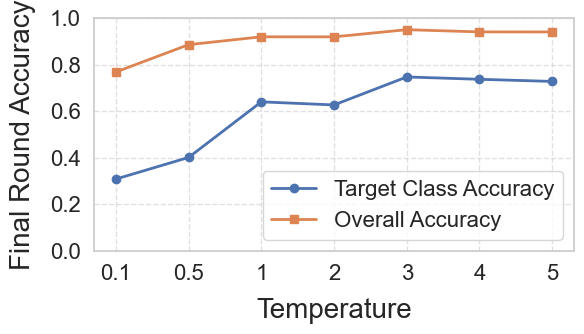

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

temps = [0.1, 0.5, 1, 2, 3, 4, 5]
final_target = [0.3081632653, 0.4010204082, 0.6397959184,
                0.6265306122, 0.7467365306, 0.7367246939,
                0.7275510204]
final_overall = [0.768, 0.8855, 0.9192, 0.9191, 0.9498, 0.9403, 0.9401]

sns.set(style="whitegrid")
plt.figure(figsize=(6, 3.5))

# Treat X as categorical to keep equal spacing
positions = range(len(temps))
plt.plot(positions, final_target, marker='o', label='Target Class Accuracy', linewidth=2)
plt.plot(positions, final_overall, marker='s', label='Overall Accuracy', linewidth=2)

plt.xlabel("Temperature", fontsize=20, labelpad=10)
plt.ylabel("Final Round Accuracy", fontsize=20, labelpad=10)
plt.ylim(0, 1)

# Set custom tick labels with equal spacing
plt.xticks(positions, temps, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("../figures/mnist T fine_tune.pdf", format="pdf")
plt.show()


plt.close()

In [14]:
import torch
import torch.nn.functional as F
import copy
def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3, temperature=3.0):
    print(f"→ Starting distillation with T = {temperature}")
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for epoch in range(distill_epochs):
        print(f"  [Distill Epoch {epoch+1}/{distill_epochs}]")
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits / temperature, dim=1)

            ensemble_logits /= len(local_models)
            output = global_model(images)
            student_log_probs = F.log_softmax(output / temperature, dim=1)
            loss = F.kl_div(student_log_probs, ensemble_logits, reduction="batchmean") * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return global_model


# Main FL loop with defense
global_model = MNISTCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)

num_rounds = 10
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=5,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=5,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregation (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    
    if rnd >= 3:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = MNISTCNN().to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    d["def_overall"].append(acc)
    d["def_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")



[Round 1]
Test Accuracy: 0.4754 | Loss: 1.5460
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9938
  Class 2: 0.4506
  Class 3: 0.7277
  Class 4: 0.0010
  Class 5: 0.4294
  Class 6: 0.9864
  Class 7: 0.0029
  Class 8: 0.1109
  Class 9: 0.9772

[Round 2]
Test Accuracy: 0.6889 | Loss: 0.9136
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9894
  Class 2: 0.8246
  Class 3: 0.9554
  Class 4: 0.2953
  Class 5: 0.7365
  Class 6: 0.9896
  Class 7: 0.3667
  Class 8: 0.7259
  Class 9: 0.9623

[Round 3]
Test Accuracy: 0.8013 | Loss: 0.6756
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.9903
  Class 2: 0.8953
  Class 3: 0.9653
  Class 4: 0.7230
  Class 5: 0.8946
  Class 6: 0.9906
  Class 7: 0.6712
  Class 8: 0.9045
  Class 9: 0.9534

[Round 4]
→ Starting distillation with T = 3.0
  [Distill Epoch 1/3]
  [Distill Epoch 2/3]
  [Distill Epoch 3/3]
Test Accuracy: 0.9051 | Loss: 0.3333
Class-wise Accuracy:
  Class 0: 0.7929
  Class 1: 0.9841
  Class 2: 0.9496
  Class 3: 0.9752
  Class 4